In [14]:
import requests, zipfile, StringIO
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import log_loss


In [222]:
import pickle

In [15]:
def read_csv_zip(filename):
    z = zipfile.ZipFile(filename+'.zip')
    df = pd.read_csv(z.open(filename))
    return df
train = read_csv_zip("train.csv")
test = read_csv_zip("test.csv")

In [17]:
train.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541


In [167]:
train.describe()

,X,Y,Year,Month,WeekDay,Hour,PdDistrict_encoded,category_encoded
count,878049.000000,878049.000000,878049.000000,878049.000000,878049.000000,878049.000000,878049.000000,878049.000000
mean,-122.422616,37.771020,2008.712046,6.436509,2.992691,13.412655,4.445310,19.338687
std,0.030354,0.456893,3.631194,3.428972,1.972023,6.549573,2.863715,10.688637
min,-122.513642,37.707879,2003.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,-122.432952,37.752427,2006.000000,3.000000,1.000000,9.000000,2.000000,16.000000
50%,-122.416420,37.775421,2009.000000,6.000000,3.000000,14.000000,4.000000,20.000000
75%,-122.406959,37.784369,2012.000000,9.000000,5.000000,19.000000,7.000000,25.000000
max,-120.500000,90.000000,2015.000000,12.000000,6.000000,23.000000,9.000000,38.000000


In [128]:
test.head()

,Id,Dates,DayOfWeek,PdDistrict,Address,X,Y
0,0,2015-05-10 23:59:00,Sunday,BAYVIEW,2000 Block of THOMAS AV,-122.399588,37.735051
1,1,2015-05-10 23:51:00,Sunday,BAYVIEW,3RD ST / REVERE AV,-122.391523,37.732432
2,2,2015-05-10 23:50:00,Sunday,NORTHERN,2000 Block of GOUGH ST,-122.426002,37.792212
3,3,2015-05-10 23:45:00,Sunday,INGLESIDE,4700 Block of MISSION ST,-122.437394,37.721412
4,4,2015-05-10 23:45:00,Sunday,INGLESIDE,4700 Block of MISSION ST,-122.437394,37.721412


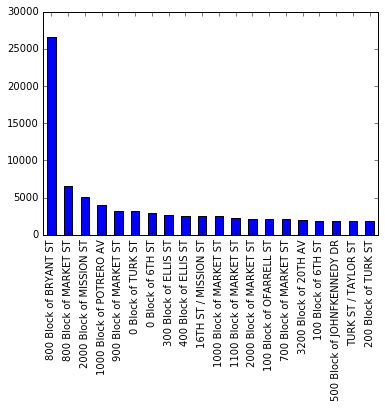

In [19]:
train["Address"].value_counts()[:20].plot(kind="bar")

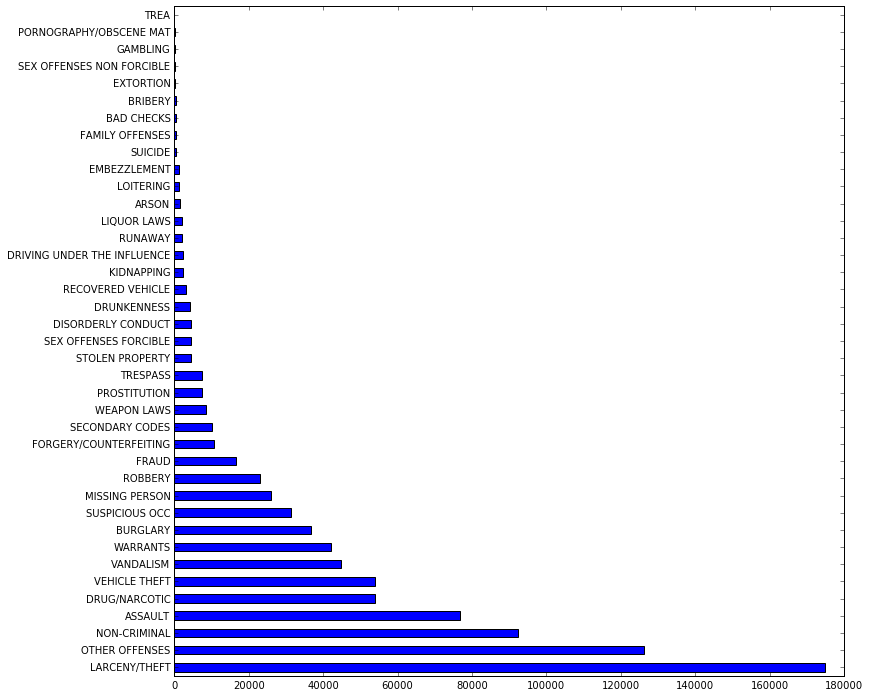

In [25]:
width = 12
height = 12
plt.figure(figsize=(width, height))
train["Category"].value_counts().plot(kind="barh")

In [39]:
train["Category"].value_counts()

LARCENY/THEFT                  174900
OTHER OFFENSES                 126182
NON-CRIMINAL                    92304
ASSAULT                         76876
DRUG/NARCOTIC                   53971
VEHICLE THEFT                   53781
VANDALISM                       44725
WARRANTS                        42214
BURGLARY                        36755
SUSPICIOUS OCC                  31414
MISSING PERSON                  25989
ROBBERY                         23000
FRAUD                           16679
FORGERY/COUNTERFEITING          10609
SECONDARY CODES                  9985
WEAPON LAWS                      8555
PROSTITUTION                     7484
TRESPASS                         7326
STOLEN PROPERTY                  4540
SEX OFFENSES FORCIBLE            4388
DISORDERLY CONDUCT               4320
DRUNKENNESS                      4280
RECOVERED VEHICLE                3138
KIDNAPPING                       2341
DRIVING UNDER THE INFLUENCE      2268
RUNAWAY                          1946
LIQUOR LAWS 

In [88]:
train["Resolution"].value_counts()

NONE                                      526790
ARREST, BOOKED                            206403
ARREST, CITED                              77004
LOCATED                                    17101
PSYCHOPATHIC CASE                          14534
UNFOUNDED                                   9585
JUVENILE BOOKED                             5564
COMPLAINANT REFUSES TO PROSECUTE            3976
DISTRICT ATTORNEY REFUSES TO PROSECUTE      3934
NOT PROSECUTED                              3714
JUVENILE CITED                              3332
PROSECUTED BY OUTSIDE AGENCY                2504
EXCEPTIONAL CLEARANCE                       1530
JUVENILE ADMONISHED                         1455
JUVENILE DIVERTED                            355
CLEARED-CONTACT JUVENILE FOR MORE INFO       217
PROSECUTED FOR LESSER OFFENSE                 51
Name: Resolution, dtype: int64

In [36]:
top_10_crime = list(train["Category"].value_counts()[:10].index)

In [37]:
top_10_crime

['LARCENY/THEFT',
 'OTHER OFFENSES',
 'NON-CRIMINAL',
 'ASSAULT',
 'DRUG/NARCOTIC',
 'VEHICLE THEFT',
 'VANDALISM',
 'WARRANTS',
 'BURGLARY',
 'SUSPICIOUS OCC']

In [50]:
import seaborn as sns
# Plotting Options
sns.set_style("whitegrid")
sns.despine()

In [85]:
def plot_bar(df, title,ylabel):
    """
    Helper function for plotting barplots.
    Color selection is made at random from a tuple of seabonrn colorsets
    """
    """
    p = (
        'Set2', 'Paired', 'colorblind', 'husl',
        'Set1', 'coolwarm', 'RdYlGn', 'spectral'
    )
    """
    color = sns.color_palette('hls', df.shape[1])
    fig = plt.figure(figsize=(15,15))
    
    bar   = df.plot(kind='barh',
                    title=title,
                    fontsize=16,
                    figsize=(12,8),
                    stacked=True,
                    width=1,
                    color=color,
    )
    plt.title(title,fontsize=20)
    
    plt.ylabel(ylabel,fontsize=20)
    # bar.figure.savefig(filename)

    plt.show()

In [46]:
address_category = train.loc[train["Category"].isin(top_10_crime)].groupby(['Address','Category']).size().unstack()

In [62]:
address_category_index = address_category.sum(1).argsort()
add_cat_count = address_category.take(address_category_index)[-20:]


TypeError: text() takes at least 4 arguments (1 given)

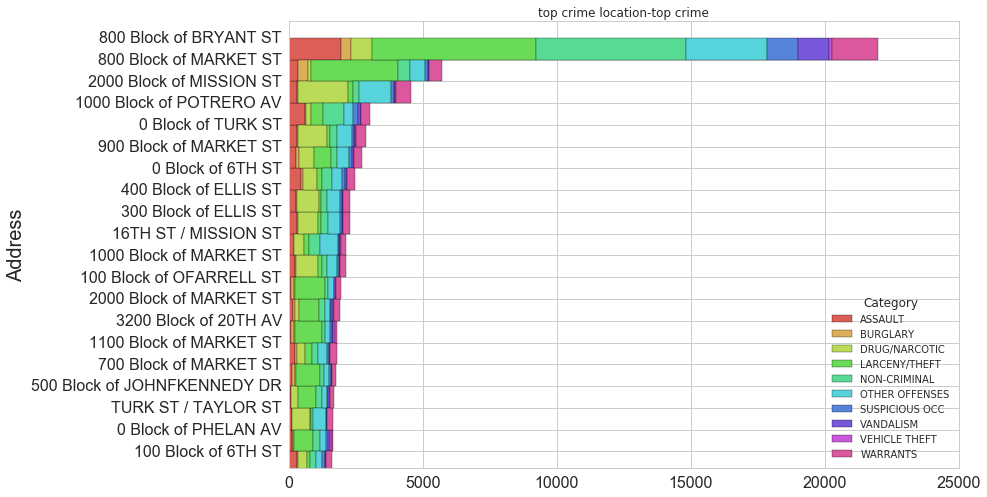

In [80]:
plot_bar(add_cat_count,'top crime location-top crime','Address')

In [77]:
add_cat_count_perc = add_cat_count.div(add_cat_count.sum(1).astype(float),axis=0)

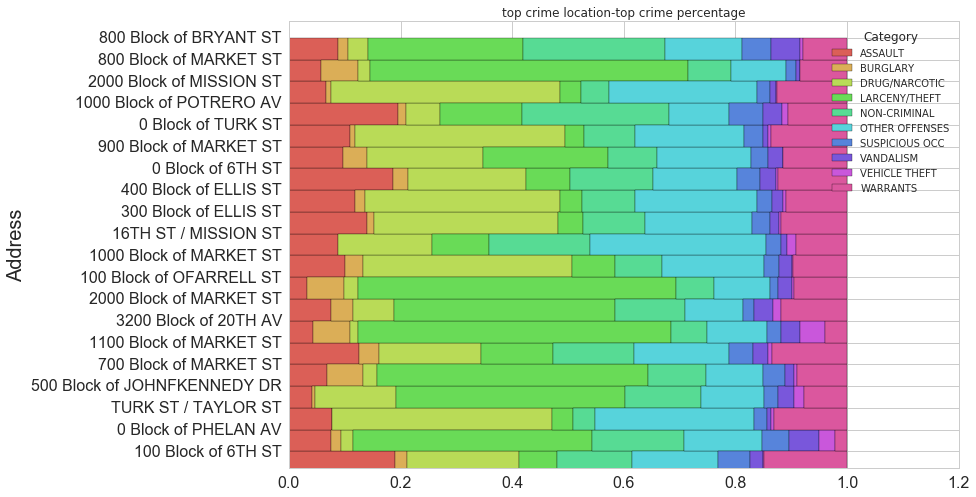

In [78]:
plot_bar(add_cat_count_perc,'top crime location-top crime percentage','Address')

In [81]:
train["PdDistrict"].value_counts()

SOUTHERN      157182
MISSION       119908
NORTHERN      105296
BAYVIEW        89431
CENTRAL        85460
TENDERLOIN     81809
INGLESIDE      78845
TARAVAL        65596
PARK           49313
RICHMOND       45209
Name: PdDistrict, dtype: int64

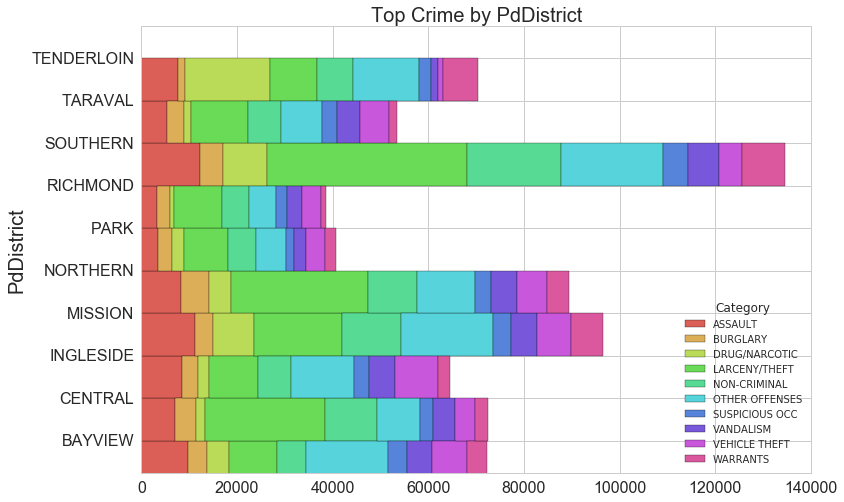

In [86]:
pd_category = train.loc[train["Category"].isin(top_10_crime)].groupby(['PdDistrict','Category']).size().unstack()
plot_bar(pd_category,"Top Crime by PdDistrict","PdDistrict")

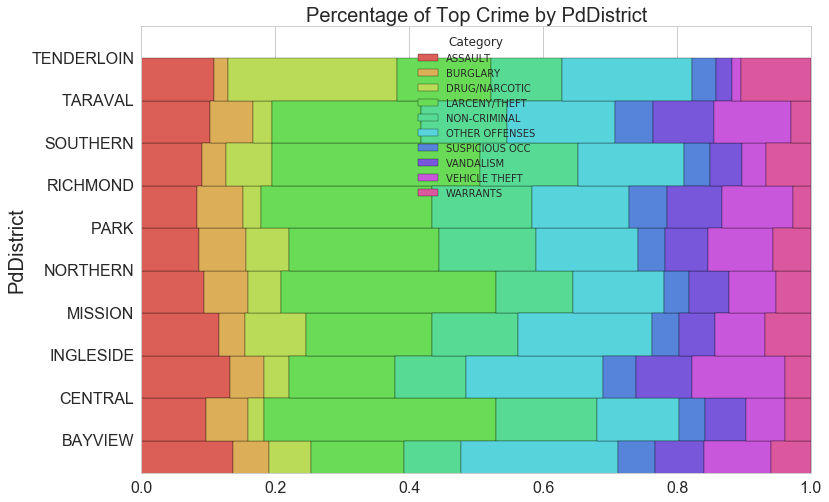

In [87]:
pd_category_percent = pd_category.div(pd_category.sum(1).astype(float),axis=0)
plot_bar(pd_category_percent,"Percentage of Top Crime by PdDistrict","PdDistrict")

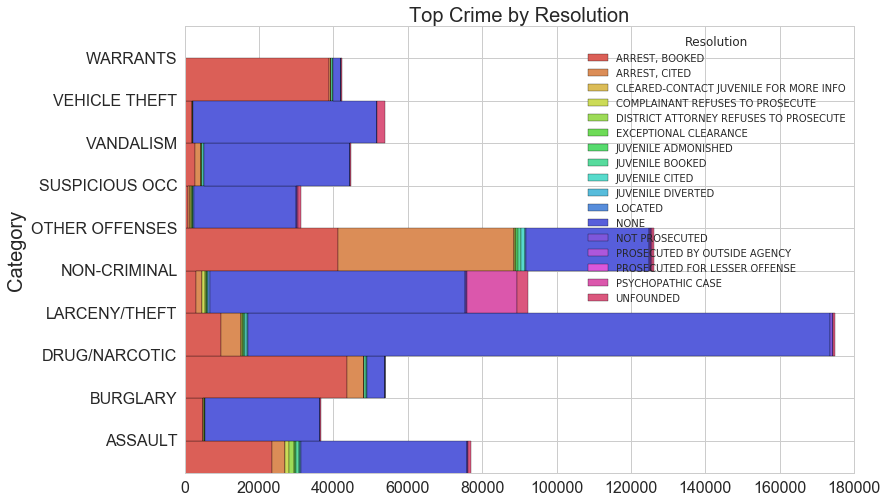

In [89]:
category_resolution = train.loc[train["Category"].isin(top_10_crime)].groupby(['Category','Resolution']).size().unstack()
plot_bar(category_resolution,"Top Crime by Resolution","Category")

In [105]:
def DateTimeFeature(df,dateColumn):
    df["DateIndex"] = pd.to_datetime(df[dateColumn])
    df["Year"] = df["DateIndex"].apply(lambda x: x.year)
    df["Month"] = df["DateIndex"].apply(lambda x: x.month)
    df["WeekDay"] = df["DateIndex"].apply(lambda x: x.weekday())
    df["Hour"] = df["DateIndex"].apply(lambda x: x.hour)   



In [106]:
DateTimeFeature(train,"Dates")

In [129]:
DateTimeFeature(test,"Dates")

In [107]:
train.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y,DateIndex,Year,Month,WeekDay,Hour
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,2015-05-13 23:53:00,2015,5,2,23
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,2015-05-13 23:53:00,2015,5,2,23
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414,2015-05-13 23:33:00,2015,5,2,23
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873,2015-05-13 23:30:00,2015,5,2,23
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541,2015-05-13 23:30:00,2015,5,2,23


top 10 crime 
'LARCENY/THEFT',
 'OTHER OFFENSES',
 'NON-CRIMINAL',
 'ASSAULT',
 'DRUG/NARCOTIC',
 'VEHICLE THEFT',
 'VANDALISM',
 'WARRANTS',
 'BURGLARY',
 'SUSPICIOUS OCC'

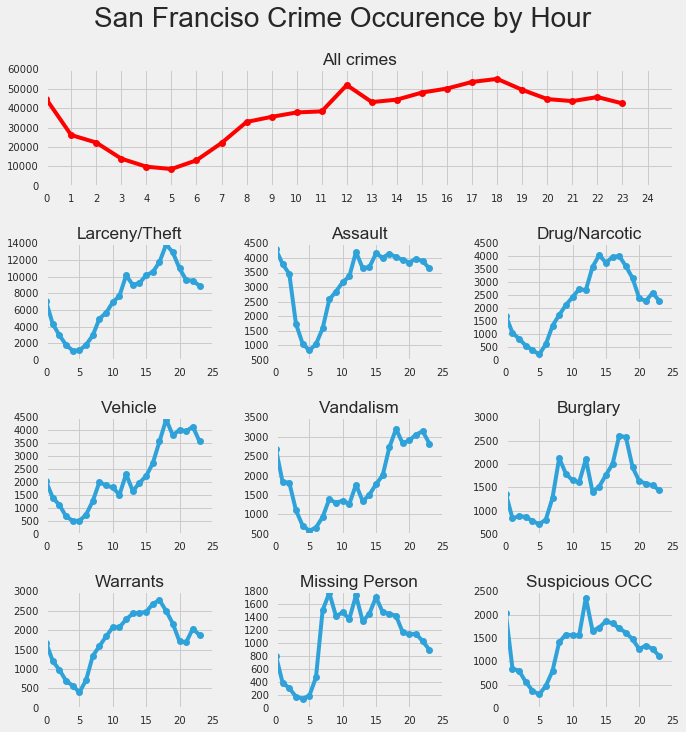

In [101]:
import pylab

pylab.rcParams['figure.figsize'] = (10.0, 10.0)
with plt.style.context('fivethirtyeight'):
    ax1 = plt.subplot2grid((4,3), (0,0), colspan=3)
    ax1.plot(train.groupby('Hour').size(), 'ro-')
    ax1.set_title ('All crimes')
    start, end = ax1.get_xlim()
    ax1.xaxis.set_ticks(np.arange(start, end, 1))
    
    ax2 = plt.subplot2grid((4,3), (1, 0))
    ax2.plot(train.loc[train["Category"]=='LARCENY/THEFT'].groupby('Hour').size(), 'o-')
    ax2.set_title ('Larceny/Theft')
    
    ax3 = plt.subplot2grid((4,3), (1, 1))
    ax3.plot(train.loc[train["Category"]=='ASSAULT'].groupby('Hour').size(), 'o-')
    ax3.set_title ('Assault')
    
    ax4 = plt.subplot2grid((4,3), (1, 2))
    ax4.plot(train.loc[train["Category"]=='DRUG/NARCOTIC'].groupby('Hour').size(), 'o-')
    ax4.set_title ('Drug/Narcotic')
    
    ax5 = plt.subplot2grid((4,3), (2, 0))
    ax5.plot(train.loc[train["Category"]=='VEHICLE THEFT'].groupby('Hour').size(), 'o-')
    ax5.set_title ('Vehicle')
    
    ax6 = plt.subplot2grid((4,3), (2, 1))
    ax6.plot(train.loc[train["Category"]=='VANDALISM'].groupby('Hour').size(), 'o-')
    ax6.set_title ('Vandalism')
    
    ax7 = plt.subplot2grid((4,3), (2, 2))
    ax7.plot(train.loc[train["Category"]=='BURGLARY'].groupby('Hour').size(), 'o-')
    ax7.set_title ('Burglary')
    
    ax8 = plt.subplot2grid((4,3), (3, 0))
    ax8.plot(train.loc[train["Category"]=='WARRANTS'].groupby('Hour').size(), 'o-')
    ax8.set_title ('Warrants')
    
    ax9 = plt.subplot2grid((4,3), (3, 1))
    ax9.plot(train.loc[train["Category"]=='MISSING PERSON'].groupby('Hour').size(), 'o-')
    ax9.set_title ('Missing Person')
    
    ax10 = plt.subplot2grid((4,3), (3, 2))
    ax10.plot(train.loc[train["Category"]=='SUSPICIOUS OCC'].groupby('Hour').size(), 'o-')
    ax10.set_title ('Suspicious OCC')
    
    
    
    
  
    pylab.gcf().text(0.5, 1.03, 
                    'San Franciso Crime Occurence by Hour',
                     horizontalalignment='center',
                     verticalalignment='top', 
                     fontsize = 28)
    
plt.tight_layout(2)
plt.show()

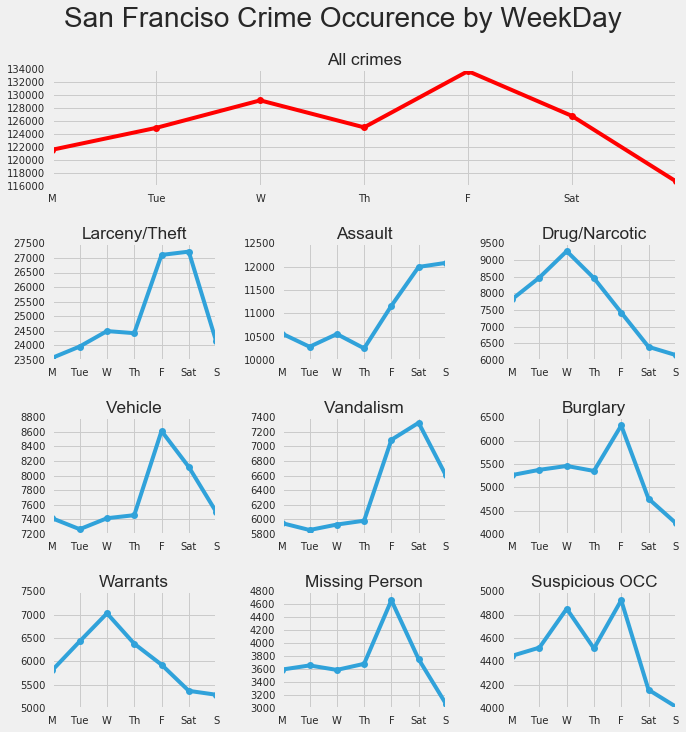

In [109]:
pylab.rcParams['figure.figsize'] = (10.0, 10.0)
daysOfWeekLit = ['M', 'Tue', 'W', 'Th', 'F', 'Sat', 'S']
with plt.style.context('fivethirtyeight'):
    ax1 = plt.subplot2grid((4,3), (0,0), colspan=3)
    ax1.plot(train.groupby('WeekDay').size(), 'ro-')
    ax1.set_title ('All crimes')
    start, end = ax1.get_xlim()
    ax1.xaxis.set_ticks(np.arange(start, end, 1))
    ax1.set_xticklabels(daysOfWeekLit)
    
    ax2 = plt.subplot2grid((4,3), (1, 0))
    ax2.plot(train.loc[train["Category"]=='LARCENY/THEFT'].groupby('WeekDay').size(), 'o-')
    ax2.set_title ('Larceny/Theft')
    ax2.set_xticklabels(daysOfWeekLit)
    
    ax3 = plt.subplot2grid((4,3), (1, 1))
    ax3.plot(train.loc[train["Category"]=='ASSAULT'].groupby('WeekDay').size(), 'o-')
    ax3.set_title ('Assault')
    ax3.set_xticklabels(daysOfWeekLit)
    
    ax4 = plt.subplot2grid((4,3), (1, 2))
    ax4.plot(train.loc[train["Category"]=='DRUG/NARCOTIC'].groupby('WeekDay').size(), 'o-')
    ax4.set_title ('Drug/Narcotic')
    ax4.set_xticklabels(daysOfWeekLit)
    
    ax5 = plt.subplot2grid((4,3), (2, 0))
    ax5.plot(train.loc[train["Category"]=='VEHICLE THEFT'].groupby('WeekDay').size(), 'o-')
    ax5.set_title ('Vehicle')
    ax5.set_xticklabels(daysOfWeekLit)
    
    ax6 = plt.subplot2grid((4,3), (2, 1))
    ax6.plot(train.loc[train["Category"]=='VANDALISM'].groupby('WeekDay').size(), 'o-')
    ax6.set_title ('Vandalism')
    ax6.set_xticklabels(daysOfWeekLit)
    
    ax7 = plt.subplot2grid((4,3), (2, 2))
    ax7.plot(train.loc[train["Category"]=='BURGLARY'].groupby('WeekDay').size(), 'o-')
    ax7.set_title ('Burglary')
    ax7.set_xticklabels(daysOfWeekLit)
    
    ax8 = plt.subplot2grid((4,3), (3, 0))
    ax8.plot(train.loc[train["Category"]=='WARRANTS'].groupby('WeekDay').size(), 'o-')
    ax8.set_title ('Warrants')
    ax8.set_xticklabels(daysOfWeekLit)
    
    ax9 = plt.subplot2grid((4,3), (3, 1))
    ax9.plot(train.loc[train["Category"]=='MISSING PERSON'].groupby('WeekDay').size(), 'o-')
    ax9.set_title ('Missing Person')
    ax9.set_xticklabels(daysOfWeekLit)
    
    ax10 = plt.subplot2grid((4,3), (3, 2))
    ax10.plot(train.loc[train["Category"]=='SUSPICIOUS OCC'].groupby('WeekDay').size(), 'o-')
    ax10.set_title ('Suspicious OCC')
    ax10.set_xticklabels(daysOfWeekLit)
    
    
    
    
  
    pylab.gcf().text(0.5, 1.03, 
                    'San Franciso Crime Occurence by WeekDay',
                     horizontalalignment='center',
                     verticalalignment='top', 
                     fontsize = 28)
    
plt.tight_layout(2)
plt.show()

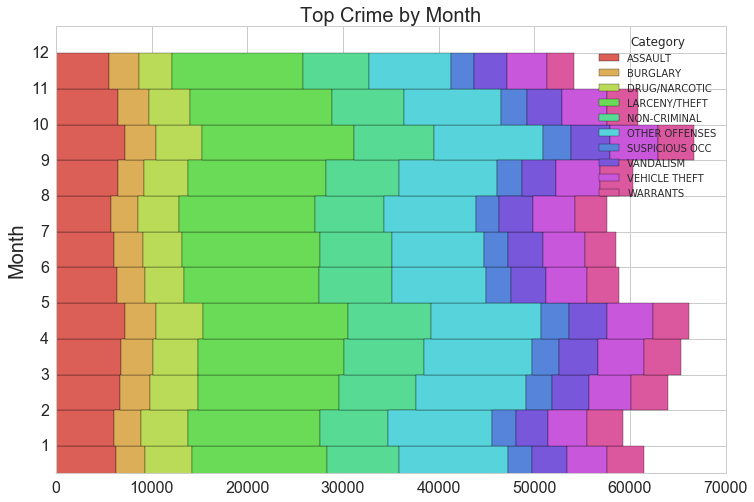

In [110]:
month_category = train.loc[train["Category"].isin(top_10_crime)].groupby(['Month','Category']).size().unstack()
plot_bar(month_category,"Top Crime by Month","Month")

In [113]:
from sklearn import preprocessing,linear_model,cross_validation 

In [114]:
pd_district_encoded = preprocessing.LabelEncoder()
pd_district_encoded.fit(train["PdDistrict"])
train["PdDistrict_encoded"] = pd_district_encoded.transform(train["PdDistrict"])



In [165]:
district = pd.get_dummies(train["PdDistrict"])
Month = pd.get_dummies(train["Month"])
DayofWeek = pd.get_dummies(train["DayOfWeek"])
train_categorical = pd.concat([district,Month,DayofWeek],axis=1)
train_categorical.head()
categorical_feature = list(train_categorical.columns.values)

,BAYVIEW,CENTRAL,INGLESIDE,MISSION,NORTHERN,PARK,RICHMOND,SOUTHERN,TARAVAL,TENDERLOIN,...,10,11,12,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [170]:
categorical_feature = ["PdDistrict","Month","DayOfWeek"]
def categorical_feature_preprocess(categorical_feature,dataset):
    list_categorical = []
    for col in categorical_feature:
        dummy = pd.get_dummies(dataset[col])
        list_categorical.append(dummy)
    dataset_categorical = pd.concat(list_categorical,axis=1)
    return dataset_categorical

train_categorical = categorical_feature_preprocess(categorical_feature,train)

In [171]:
test_categorical = categorical_feature_preprocess(categorical_feature,test)

In [ ]:
continuous_feature = ["Year","Hour","X","Y"]
def numerical_feature_preprocess(continuous_feature,train,test):
    scaler = StandardScaler()
    for col in continuous_feature:
        scaler.fit(train[col])
        train[col] = scaler.transform(train[col].reshape(-1, 1))
        test[col] = scaler.transform(test[col].reshape(-1, 1))
numerical_feature_preprocess(continuous_feature,train,test)  

In [174]:
train.describe()

,X,Y,Year,Month,WeekDay,Hour,PdDistrict_encoded,category_encoded
count,8.780490e+05,8.780490e+05,8.780490e+05,878049.000000,878049.000000,8.780490e+05,878049.000000,878049.000000
mean,5.777453e-13,-1.040711e-14,-1.228077e-12,6.436509,2.992691,-1.291517e-15,4.445310,19.338687
std,1.000001e+00,1.000001e+00,1.000001e+00,3.428972,1.972023,1.000001e+00,2.863715,10.688637
min,-2.998840e+00,-1.381971e-01,-1.573050e+00,1.000000,0.000000,-2.047868e+00,0.000000,0.000000
25%,-3.404912e-01,-4.069427e-02,-7.468748e-01,3.000000,1.000000,-6.737321e-01,2.000000,16.000000
50%,2.041550e-01,9.631161e-03,7.930022e-02,6.000000,3.000000,8.967695e-02,4.000000,20.000000
75%,5.158463e-01,2.921524e-02,9.054753e-01,9.000000,5.000000,8.530860e-01,7.000000,25.000000
max,6.334063e+01,1.143134e+02,1.731650e+00,12.000000,6.000000,1.463813e+00,9.000000,38.000000


In [130]:
test["PdDistrict_encoded"] = pd_district_encoded.transform(test["PdDistrict"])


In [122]:
category_encoded = preprocessing.LabelEncoder()
category_encoded.fit(train["Category"])
train["category_encoded"] = category_encoded.transform(train["Category"])


In [116]:
print train.columns
print train.shape

Index([u'Dates', u'Category', u'Descript', u'DayOfWeek', u'PdDistrict',
       u'Resolution', u'Address', u'X', u'Y', u'DateIndex', u'Year', u'Month',
       u'WeekDay', u'Hour', u'PdDistrict_encoded'],
      dtype='object')
(878049, 15)


In [197]:
#lg_train = linear_model.LogisticRegression(C = 0.1,class_weight ='balanced',solver = 'lbfgs', multi_class = 'multinomial')
lg_train = linear_model.LogisticRegression()

# train_feature = ['PdDistrict_encoded','Year','Month','Hour','WeekDay','X','Y']


In [175]:
train_data = pd.concat([train[continuous_feature],train_categorical],axis=1)
test_data = pd.concat([test[continuous_feature],test_categorical],axis=1)
train_data.head()
test_data.head()

,Year,Hour,X,Y,BAYVIEW,CENTRAL,INGLESIDE,MISSION,NORTHERN,PARK,...,10,11,12,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,1.73165,1.463813,0.758683,-0.078726,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,1.73165,1.463813,1.024378,-0.084457,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,1.73165,1.463813,-0.111535,0.046383,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
3,1.73165,1.463813,-0.486846,-0.108577,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,1.73165,1.463813,-0.486846,-0.108577,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [198]:
lg_train.fit(train_data,train['category_encoded'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [199]:
np.mean((train["category_encoded"]==lg_train.predict(train_data)))

0.22514347149190991

In [200]:
log_loss(train["category_encoded"],np.array(lg_train.predict_proba(train_data)))

2.5902560933374374

In [206]:
scores = cross_validation.cross_val_score(lg_train,train_data,train['category_encoded'],cv=5,scoring='log_loss')

In [207]:
print scores

[-2.69171954 -2.59656487 -2.58113982 -2.59573325 -2.69795292]


In [219]:
lg_predict = lg_train.predict_proba(test_data)
lg_result = pd.DataFrame(lg_predict,columns =category_encoded.classes_)
lg_result.head()
lg_result.to_csv("logistic.csv",index=True,index_label ='Id' )



In [220]:
print lg_result[:100]


       ARSON   ASSAULT  BAD CHECKS   BRIBERY  BURGLARY  DISORDERLY CONDUCT  \
0   0.002637  0.111350    0.000032  0.001130  0.030572            0.000981   
1   0.002872  0.113994    0.000033  0.001205  0.030467            0.001020   
2   0.000820  0.077412    0.000041  0.000320  0.036981            0.001653   
3   0.001336  0.106417    0.000033  0.001164  0.028820            0.000837   
4   0.001336  0.106417    0.000033  0.001164  0.028820            0.000837   
5   0.001419  0.086125    0.000048  0.000563  0.034551            0.001050   
6   0.001415  0.113873    0.000036  0.001258  0.029729            0.000915   
7   0.001609  0.119705    0.000039  0.001397  0.029951            0.000986   
8   0.000743  0.096365    0.000033  0.001033  0.021790            0.003743   
9   0.000704  0.076067    0.000061  0.000254  0.034395            0.002116   
10  0.001633  0.122449    0.000040  0.001432  0.030263            0.001016   
11  0.000813  0.098718    0.000034  0.001103  0.021748          

In [223]:
with open('logistic.pkl','wb') as s:
        pickle.dump(lg_train,s)